https://www.tensorflow.org/tutorials/keras/regression

- why? 가격이나 확률같이 연속되는 출력 값을 예측하는 것이 목적
- what? Auto MPG 데이터셋을 사용하여 1970년 후반~1980년대 초반 자동차 연비 예측
- 실린더의 개수, 이동거리, 마력, 가속력, 출시년도, 출시 국가 등의 feature
- MPG(miles per gallon)가 예측값 (label)


출처: https://gmnam.tistory.com/183 [Voyager]

In [1]:
#필요한 라이브러리 import 하기
#산점도를 그리기 위해서 seaborn패키지 설치

In [2]:
import matplotlib.pyplot as plt # 자료 시각화하는 차트그리기
import numpy as np #연산
import pandas as pd #행과 열로 데이터 객체를 다룸, Pandas는 구조적 데이터를 로드하고 처리하는 데 유용한 여러 유틸리티가 포함된 Python 라이브러리입니다.
import seaborn as sns

In [3]:
np.set_printoptions(precision=3, suppress=True)
#pricision(출력값)은 소수점 3째자리, 매서드에서 suppress를 true로 할 경우 실수로 보여준다. false로 할 경우 1e3일 때 과학적 표기법
#기본은 false로설정 되어있음

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
# Sequential 모델 생성은 각 레이어에 정확히 하나의 입력 텐서와 하나의 출력 텐서가 있는 일반 레이어 스택에 적합합니다.
from tensorflow.keras.layers.experimental import preprocessing #전처리를 하기 위함
print(tf.__version__)

2.5.0


데이터셋 가져오기

>판다스를 이용해서 데이터를 읽기

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

#데이터를 다음 주소로 부터 다운 받기
#pandas data형태로 나타내기
#저장 시 각 데이터를 칼럼으로 지정한다.

# na_values: 결측치 값이 '?' 등의 다양한 모양으로 있을 수 있는데, 이들을 결측값으로 인식하라고 알려주는 것
# comment: if comment='#', parsing #empty\na,b,c\n1,2,3 with header=0 will result in 'a,b,c' being treated as the header.
# skipinitialspace: If True , the initial whitespaces will be removed.

In [6]:
dataset = raw_dataset.copy() # 원본을 유지하기 위해서 카피함
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


데이터정리

In [7]:
dataset.isna().sum() # isna()누락된 값을 찾는 함수 #연비 mpg Miles Per Gallon: 1갤런으로 주행한 마일

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna() # .dropna() : 만약 누락된 column이 있으면 모두 삭제한다.

https://devuna.tistory.com/67

Origin 컬럼의 index를 국가명으로 map을 이용해 바꾸어준다

출처: https://gmnam.tistory.com/183 [Voyager]

In [9]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'}) 
# 원핫인코딩을 하지 않으면 1,2,3 숫자 사이에 순서나 대소관게가 형성될 수 있음.
# map을 이용해 각 숫자를 나라 이름으로 매핑해줌

위의 결과와 같이 바뀐 것을 확인한 후, get_dummies를 이용해 Origin을 3개의 feature를 갖는 one-hot encoding 형태로 변환해준다. 
#범주형이니 원핫 인코딩 #수치형으로 표시

출처: https://gmnam.tistory.com/183 [Voyager]

In [10]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

#수치화된 데이터를 가변수화하여 나타내 기계학습 시키기 #관계값이 없는데 수치형 데이터로만 변화하게 되면 서로간의 관계성이 생김
#pd.get_dummies 처리 : 결측값을 제외하고 0과 1로 구성된 더미값이 만들어진다
#dataset.tail() 매서드는 데이텅의 수가 많아 출력 요약하는 법(뒷쪽부분 .tail()/ 앞쪽부분 볼때 .head())

#출처: https://devuna.tistory.com/67 [튜나 개발일기]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


테이터 train과 test 분할

In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
#데이터셋을 훈련 세트와 테스트 세트로 분할하기
#frac인수로 지정된 비율만큼의 행을 랜덤하게 뽑아서 새로운 데이터프레임을 만듭니다. 특정비율만큼 무작위 추출
## 여기에서는 pandas dataframe의 sample 매서드를 이용해 dataset의 80%를 train_dataset으로 할당하였고, 이때 random_state는 0으로 주었다. 따라서 dataset의 앞 80%가 훈련 세트로 지정된다. 나머지 20%은 검증을 위한 세트가 된다. 
#출처: https://gmnam.tistory.com/183 [Voyager]

# 데이터셋을 트레인, 테스트로 8:2 분할, 보통 train_test_split(dataset,test_size=0.2)

#frac=1로 지정했다면 100%, 즉 모든 데이터를 뽑아서 섞는 것과 동일한 효과를 가집니다.
#random_state = 난수 고정화,  세트를 섞을 때 해당 int 값을 보고 섞으며, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지할 수 있습니다.

In [12]:
test_dataset.shape


(78, 10)

In [13]:
train_dataset.shape


(314, 10)

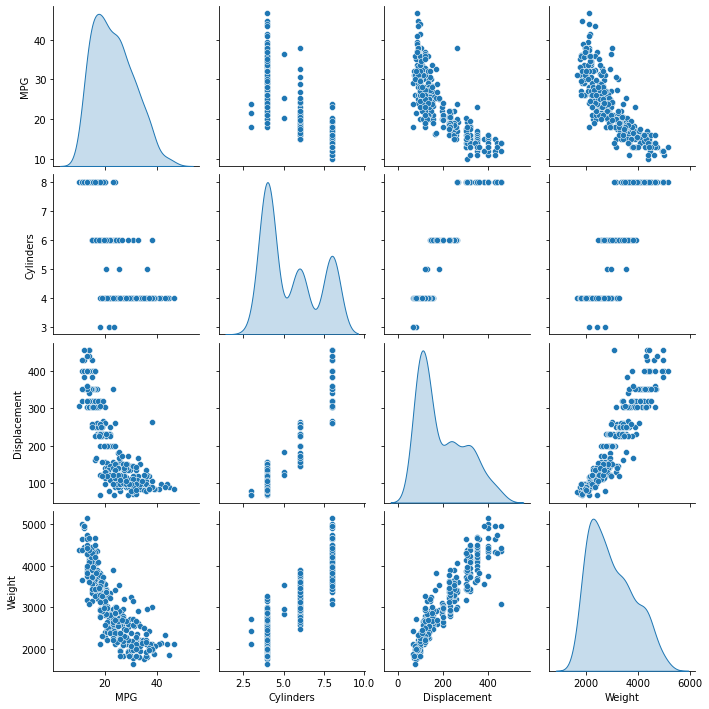

In [14]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde') #산점도, 변수별 커널밀도추정곡선


#MPG 연비,Cylinders 몇기통 , 출력량  displacement 배기량
# diag_kind: 그래프 방식: diag_kind{‘auto’, ‘hist’, ‘kde’, None}
#hue='species'를 사용하여 'species' 종(setosa, versicolor, virginica) 별로 색깔을 다르게 표시하여 추가적인 정보를 알 수 있도록 하였습니다.
#출처: https://rfriend.tistory.com/416 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]

In [15]:
train_dataset.describe().transpose() # tranpose 행렬바꾸기 # describe 전반적인 통계

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


레이블에서 피처 분할



In [16]:
train_features = train_dataset.copy() #얕은 카피 발생
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG') #pop : 리스트 요소 제거하는 메소드. 여기서는 mpg 변수는 label값이므로 train dataset에서 mpg값을 끄집어 내 삭제한다
test_labels = test_features.pop('MPG')

In [17]:
train_dataset.describe().transpose()[['mean', 'std']] #표준화 작업을 직접 하기 위해 transpose() 처리를 해주기. 평균과 표준편차보기

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


정규화(Nomalization)
- 각 차원의 데이터가 동일한 범위내의 값을 갖도록 하는 전처리 기법
- why? 특성의 스케일과 범위가 다르면 정규화를 하기
안하면 모델이 수렴할 수 있지만 훈련하기 어렵다.
따라서 scale을 통일시키는 작업이 필요하다
-compact 하게 만들고 값의 범위를 축소시킨다.(if not, 값이 크면 노이즈 데이터 생성, overfitting 될 수 있다.), 활성함수 의미있게 하기 위해서 필요하다. 
- how? 평균값과 표준편차가 필요, 쉽게 하기 위해서 describe 함수 필요
- 다양한 전처리
- http://aikorea.org/cs231n/neural-networks-2-kr/

preprocessing.Normalization 계층은 모델에 전처리를 할 때 
 


In [18]:
normalizer = preprocessing.Normalization(axis=-1) #정규화되어야 하는 축

In [19]:
normalizer.adapt(np.array(train_features)) 
#train_features 데이타를 layer에 adapt(적용) 시켜준다. 이 과정에서 각 feature별 평균과 표준편차 값이 계산된다. 

#출처: https://gmnam.tistory.com/183 [Voyager]

In [20]:
print(normalizer.mean.numpy()) # 평균 및 분산을 계산하고 레이어에 저장

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [21]:
first = np.array(train_features[:1]) #각 기능은 독립적으로 정규화됩니다.

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## 모델 학습 순서 > test_results에 넣고 정확도를 비교
Linear regression
- single inputs > multiple inputs 

DNN regression
- single inputs > multiple inputs 

선형회귀
single inputs

In [22]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)
#horsepower만을 이용해 MPG를 예측하는 모델을 만들고 결과를 확인한다. 
#신경망 모델을 만들기 전에 규격화 layer를 정의하고, horsepower 데이터로 adapt 해준다. 
#출처: https://gmnam.tistory.com/183 [Voyager]

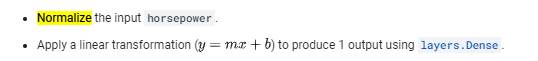

In [23]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()
#단일 뉴런을 가지는 모델을 만들고 summary()로 구조를 확인한다
#출처: https://gmnam.tistory.com/183 [Voyager]

#Dense layer에서 훈련 가능한 매개변수가 2개인 것을 확인할 수 있다. 
#이것은 weight과 bias이다. 또한, normalization layer에 3개의 훈련 대상이 아닌 변수를 확인할 수 있다. 규격화 층에서 변수의 개수가 어떻게 정해지에 대해서는 나중에 공부하기로 하자.
#출처: https://gmnam.tistory.com/183 [Voyager]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


처음 10마력 값에서 훈련되지 않은 모델을 실행합니다. 출력은 좋지 않지만 예상 된 모양이 있음을 알 수 있습니다.(10,1)

In [24]:
horsepower_model.predict(horsepower[:10])

array([[ 1.25 ],
       [ 0.706],
       [-2.307],
       [ 1.752],
       [ 1.584],
       [ 0.622],
       [ 1.877],
       [ 1.584],
       [ 0.413],
       [ 0.706]], dtype=float32)

매서드 model.compile(()을 활용해서 최적화 방법과 loss 함수를 정의하여 컴파일 하기
Adam을 optimizer로 사용하고,  loss를 mean_absolute_error로 할당

In [25]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

이제 모델을 훈련시킬 수 있다. validation_split을 20%로 주어 훈련과 검증이 동시에 진행되도록 한다. 100번의 반복으로 모델을 훈련시켰고 verbose=0을 주어 훈련 중간 과정 출력을 생략하도록 한다. 



출처: https://gmnam.tistory.com/183 [Voyager]

In [26]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.65 s, sys: 139 ms, total: 2.78 s
Wall time: 2.91 s


history object에서 저장된 상태로 모델 트레이닝 진행을 시각화하기

In [27]:
hist

#필요한 라이브러리 import 하기
#산점도를 그리기 위해서 seaborn패키지 설치
import matplotlib.pyplot as plt # 자료 시각화하는 차트그리기
import numpy as np #연산
import pandas as pd #행과 열로 데이터 객체를 다룸, Pandas는 구조적 데이터를 로드하고 처리하는 데 유용한 여러 유틸리티가 포함된 Python 라이브러리입니다.
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)
#pricision(출력값)은 소수점 3째자리, 매서드에서 suppress를 true로 할 경우 실수로 보여준다. false로 할 경우 1e3일 때 과학적 표기법
#기본은 false로설정 되어있음
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
# Sequential 모델 생성은 각 레이어에 정확히 하나의 입력 텐서와 하나의 출력 텐서가 있는 일반 레이어 스택에 적합합니다.
from tensorflow.keras.layers.experimental import preprocessing #전처리를 하기 위함
print(tf.__version__)
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
         

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.803388,4.199890,95
96,3.805984,4.210970,96
97,3.806188,4.190248,97
98,3.802022,4.185576,98
99,3.803395,4.197226,99


In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

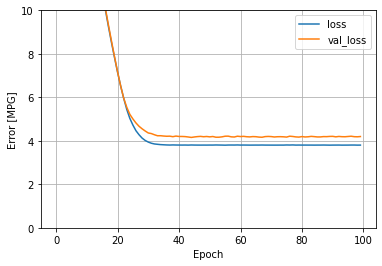

In [30]:
plot_loss(history)

In [31]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)
test_results

{'horsepower_model': 3.6538922786712646}

In [32]:
x = tf.linspace(0.0, 250, 251) # x: 0-250까지, 251개의 숫자를 생성
y = horsepower_model.predict(x)

In [33]:
train_features['Horsepower'].shape


(314,)

In [34]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

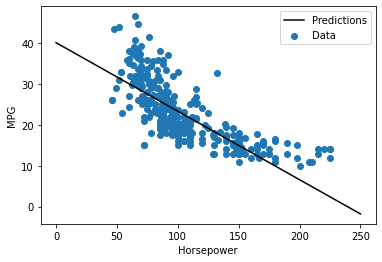

In [35]:
plot_horsepower(x,y)

Multiple inputs



In [36]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [37]:

linear_model.summary()

# trainable 10개: 9개의 weights, 1개의 bias
# 19개의 훈련하지 않아도 되는 변수가 생성됐음

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [38]:
horsepower_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [39]:
linear_model.predict(train_features[:10])
# trainable 10개: 9개의 weights, 1개의 bias
# 19개의 훈련하지 않아도 되는 변수가 생성됐음

array([[ 1.049],
       [-0.057],
       [-0.654],
       [ 0.644],
       [ 0.291],
       [-0.188],
       [ 0.339],
       [-1.137],
       [ 0.125],
       [ 0.344]], dtype=float32)

In [40]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.101],
       [ 0.089],
       [-0.388],
       [-0.387],
       [-0.34 ],
       [-0.237],
       [-0.021],
       [ 0.177],
       [ 0.226]], dtype=float32)>

In [41]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [42]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.72 s, sys: 144 ms, total: 2.87 s
Wall time: 2.74 s


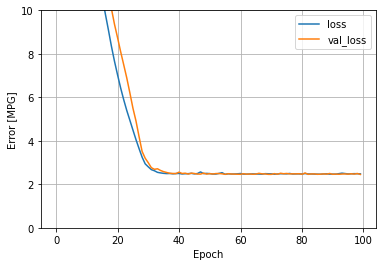

In [43]:
plot_loss(history)

In [44]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)
test_results

{'horsepower_model': 3.6538922786712646, 'linear_model': 2.4590563774108887}

In [45]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [46]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [47]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [48]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.24 s, sys: 177 ms, total: 3.41 s
Wall time: 3.11 s


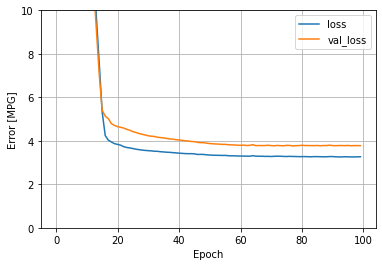

In [49]:
plot_loss(history)

In [50]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

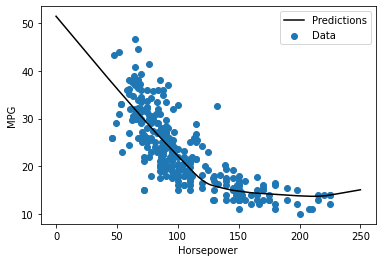

In [51]:
plot_horsepower(x, y)

In [52]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [53]:
train_features


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [54]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [55]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.28 s, sys: 200 ms, total: 3.48 s
Wall time: 3.15 s


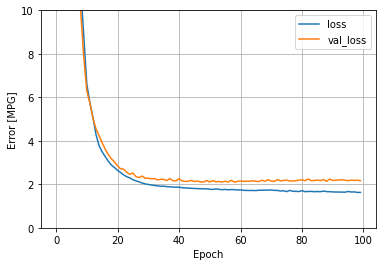

In [56]:
plot_loss(history)

In [57]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

4가지 분석 결과

In [58]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.653892
linear_model,2.459056
dnn_horsepower_model,2.908718
dnn_model,1.715195


In [59]:
test_features


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
9,8,390.0,190.0,3850.0,8.5,70,0,0,1
25,8,360.0,215.0,4615.0,14.0,70,0,0,1
28,8,304.0,193.0,4732.0,18.5,70,0,0,1
31,4,113.0,95.0,2228.0,14.0,71,0,1,0
33,6,232.0,100.0,2634.0,13.0,71,0,0,1
...,...,...,...,...,...,...,...,...,...
369,4,112.0,88.0,2395.0,18.0,82,0,0,1
375,4,105.0,74.0,1980.0,15.3,82,1,0,0
382,4,108.0,70.0,2245.0,16.9,82,0,1,0
384,4,91.0,67.0,1965.0,15.7,82,0,1,0


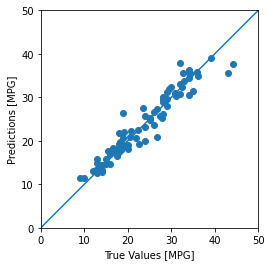

In [60]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

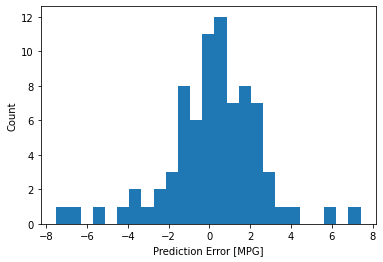

In [61]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [62]:
dnn_model.save('dnn_model')


INFO:tensorflow:Assets written to: dnn_model/assets


In [63]:

reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [64]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T


,Mean absolute error [MPG]
horsepower_model,3.653892
linear_model,2.459056
dnn_horsepower_model,2.908718
dnn_model,1.715195
reloaded,1.715195
